## Fine Tuning LLM (Phi3/Phi2) on Custom Dataset

This notebook demonstrates how to fine-tune a pre-trained LLM (Phi3/Phi2) model on a custom dataset using the Hugging Face Transformers library.

Plan of Attack:
- Data Analysis
- Model Loading
- Parameter Efficient Fine-Tuning (PEFT)
  - QLORA (8-bit)
- Model Training
- Model Save and Load

## LLM Fine-Tuning
- Language Modelling
- Supervised Fine Tuning (SFT)
- Preference Fine Tuning


In [1]:
!pip install -q accelerate -U
!pip install -q bitsandbytes -U
!pip install -q trl -U
!pip install -q peft -U
!pip install -q transformers -U
!pip install -q datasets -U

In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"

### Load Dataset

In [3]:
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict

df = pd.read_csv('https://github.com/laxmimerit/All-CSV-ML-Data-Files-Download/raw/master/amazon_product_details.csv', usecols=['category', 'about_product', 'product_name'])


In [4]:
df['category'] = df['category'].apply(lambda x: x.split('|')[-1])

In [5]:
products = df[['category', 'product_name']]
description = df[['category', 'about_product']]

products = products.rename(columns={'product_name': 'text'})
description = description.rename(columns={'about_product': 'text'})

products['task_type'] = 'Product Name'
description['task_type'] = 'Product Description'


In [6]:
df = pd.concat([products, description], ignore_index=True)

In [7]:
dataset = Dataset.from_pandas(df)
dataset = dataset.shuffle(seed=0)
dataset = dataset.train_test_split(test_size=0.1)

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['category', 'text', 'task_type'],
        num_rows: 2637
    })
    test: Dataset({
        features: ['category', 'text', 'task_type'],
        num_rows: 293
    })
})

### Hist Plot

In [9]:
# 1.5 times of total words
products['text_tokens'] = products['text'].apply(lambda x: len(x.split())*1.5)
description['text_tokens'] = description['text'].apply(lambda x: len(x.split())*1.5)


<Axes: >

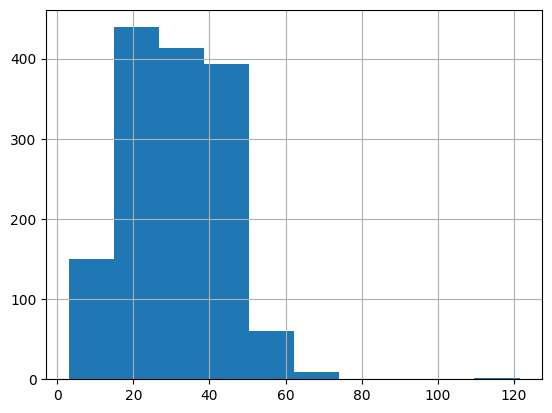

In [10]:
products['text_tokens'].hist()

<Axes: >

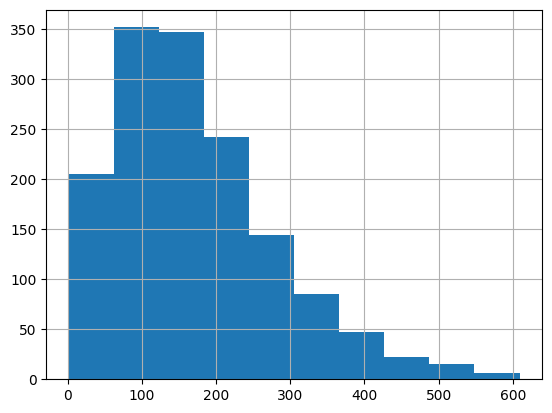

In [11]:
description['text_tokens'].hist()

## Load Base Model and Prepare Formatting

In [12]:
def formatting_func(example):
    text = f"Given the product category, you need to generate a '{example['task_type']}'.\n### Category: {example['category']}\n### {example['task_type']}: {example['text']}".strip()
    return text

In [13]:
print(formatting_func(dataset['train'][0]))

Given the product category, you need to generate a 'Product Name'.
### Category: Sewing&EmbroideryMachines
### Product Name: akiara - Makes life easy Electric Handy Sewing/Stitch Handheld Cordless Portable White Sewing Machine for Home Tailoring, Hand Machine | Mini Silai | White Hand Machine with Adapter


## Load Base Model and Tokenize

**torch_dtype:**

**Description:** This parameter specifies the data type to use for the model's weights and computations. It should be a PyTorch data type. Using a lower precision data type like torch.float16 can reduce memory usage and potentially speed up computations, especially on hardware that supports it (e.g., GPUs).

**load_in_8bit:**

**Description:** This boolean parameter indicates whether to load the model weights in 8-bit precision. Loading the model in 8-bit can significantly reduce memory usage, which is particularly useful for large models. This is typically used in conjunction with libraries like bitsandbytes that support 8-bit quantization.

In [14]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

base_model_id = "microsoft/phi-2"

model = AutoModelForCausalLM.from_pretrained(
    base_model_id, 
    trust_remote_code=True,
     torch_dtype=torch.float16,  # Data type for the model's weights and computations
    # Other possible values for torch_dtype:
    # torch_dtype=torch.float32  # Standard 32-bit floating point
    # torch_dtype=torch.float64  # Double precision 64-bit floating point
    # torch_dtype=torch.bfloat16  # Brain floating point format (16-bit)
    load_in_8bit=True  # Load the model weights in 8-bit precision
)


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

**padding_side:**

'left': Pad tokens on the left side of the sequence.

'right': Pad tokens on the right side of the sequence.

**add_eos_token:**

True: Add an end-of-sequence token to the input sequences.

False: Do not add an end-of-sequence token to the input sequences.

**add_bos_token:**

True: Add a beginning-of-sequence token to the input sequences.

False: Do not add a beginning-of-sequence token to the input sequences.

**use_fast:**

True: Use the fast tokenizer implementation if available. The fast tokenizer is typically implemented in Rust and provides better performance.

False: Use the standard Python tokenizer implementation.

**tokenizer.pad_token = tokenizer.eos_token:** This line sets the padding token to be the same as the end-of-sequence token. This can be useful for models that expect the padding token to be the same as the end-of-sequence token.

In [15]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_size='left',
    add_eos_token=True,
    add_bos_token=True,
    use_fast=False
)

tokenizer.pad_token = tokenizer.eos_token

### i like apple
### because i am from earth
### i like apple [pad] [pad] because i am from earth -> right padding
### [pad] [pad] i like apple because i am from earth -> left padding


tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

In [16]:
max_length = 400

def tokenize(prompt):
  result = tokenizer(
      formatting_func(prompt),
      truncation = True,
      max_length=max_length,
      padding = "max_length"
  )
  # This approach is particularly useful in tasks like language modeling, 
  # where the model needs to predict the next token in the sequence, 
  # and the input sequence serves as the ground truth for training.
  result['labels'] = result['input_ids'].copy()

  return result

In [17]:
print(tokenize(dataset['train'][0]))

{'input_ids': [50256, 15056, 262, 1720, 6536, 11, 345, 761, 284, 7716, 257, 705, 15667, 6530, 4458, 198, 21017, 21743, 25, 27347, 278, 5, 31567, 305, 1304, 88, 49999, 1127, 198, 21017, 8721, 6530, 25, 257, 4106, 3301, 532, 27433, 1204, 2562, 13944, 7157, 88, 27347, 278, 14, 1273, 2007, 7157, 10217, 21119, 1203, 44685, 2635, 27347, 278, 10850, 329, 5995, 21759, 3255, 11, 7157, 10850, 930, 12558, 4243, 1872, 930, 2635, 7157, 10850, 351, 43721, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 5

In [18]:
dataset = dataset.map(tokenize)

Map:   0%|          | 0/2637 [00:00<?, ? examples/s]

Map:   0%|          | 0/293 [00:00<?, ? examples/s]

## How Does the Base Model Do Out of the Box?

In [19]:
eval_prompt = """
Given the product category, you need to generate a 'Product Description'.
### Category: BatteryChargers
### Product Description:
"""

In [20]:
# tokenize -> generate -> decode

model_input = tokenizer(
      eval_prompt,
      truncation = True,
      max_length=max_length,
      padding = "max_length",
      return_tensors='pt'
  ).to("cuda")


In [21]:
model.eval()

with torch.no_grad():
  output = model.generate(
      **model_input, 
      max_new_tokens=256, # Maximum number of new tokens to generate
      repetition_penalty=1.15 # Penalty for repeating tokens
  )
  result = tokenizer.decode(
      output[0], 
      skip_special_tokens=True # Skips special tokens (e.g., padding tokens, end-of-sequence tokens) in the decoded string.
  )

  print(result)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Given the product category, you need to generate a 'Product Description'.
### Category: BatteryChargers
### Product Description:
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


Note: BaseModel can't perform the task

## LORA Config
- Lets configure 8-bit QLORA Config

In [22]:
from peft import LoraConfig, get_peft_model

# Define the target modules for LoRA (Low-Rank Adaptation)
target_modules = ["Wqkv", "fc1", "fc2"]

# Create a LoRA configuration
config = LoraConfig(
    r=32,  # Rank of the low-rank matrices
    lora_alpha=64,  # Scaling factor for the low-rank matrices
    target_modules=target_modules,  # Modules to apply LoRA
    bias="none",  # Bias initialization for the low-rank matrices
    lora_dropout=0.05,  # Dropout rate for LoRA layers
    task_type="CAUSAL_LM"  # Task type for the model
    # Other possible values for task_type:
    # task_type="SEQ_CLS"  # Sequence classification task
    # task_type="TOKEN_CLS"  # Token classification task
)

# Get the PEFT (Parameter-Efficient Fine-Tuning) model with the specified configuration
model = get_peft_model(model, config)


In [23]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [24]:
print_trainable_parameters(model)

trainable params: 26214400 || all params: 2805898240 || trainable%: 0.9342605382581515


## Model Training

In [25]:
from accelerate import Accelerator

accelerator = Accelerator(gradient_accumulation_steps=1)

model = accelerator.prepare_model(model)

In [26]:
# Trainer, Training Arguments, DataCollator

from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling
from datetime import datetime

project = "phi2-finetune"
run_name = 'train-dir'
output_dir = "./" + run_name

args=TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1, # Note: not needed if Accelerator
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
    )

trainer = Trainer(
    model=model,
    args = args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss,Validation Loss
25,0.000000,nan
50,0.000000,nan
75,0.000000,nan
100,0.000000,nan
125,0.000000,nan
150,0.000000,nan
175,0.000000,nan
200,0.000000,nan
225,0.000000,nan
250,0.000000,nan


TrainOutput(global_step=500, training_loss=0.0, metrics={'train_runtime': 3115.4958, 'train_samples_per_second': 0.321, 'train_steps_per_second': 0.16, 'total_flos': 6419582976000000.0, 'train_loss': 0.0, 'epoch': 0.37907505686125853})

## Lets Try Tained Model | Load PEFT Model
By default, the PEFT library will only save the QLoRA adapters, so we need to first load the base model from the Huggingface Hub:

Process-> Load base model,  then merge the PEFT Model

In [27]:
import torch
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    trust_remote_code=True,
    load_in_8bit=True,
    torch_dtype=torch.float16
)

eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    trust_remote_code=True,
    use_fast=False
)
eval_tokenizer.pad_token = eval_tokenizer.eos_token

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [28]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, '/kaggle/working/train-dir/checkpoint-500')

In [29]:
eval_prompt = """
Given the product category, you need to generate a 'Product Description'.
### Category: BatteryChargers
### Product Description:
"""

model_input = eval_tokenizer(eval_prompt, return_tensors="pt")

ft_model.eval()
with torch.no_grad():
  output = ft_model.generate(**model_input, max_new_tokens=256,
                                           repetition_penalty=1.15)
  result = eval_tokenizer.decode(output[0], skip_special_tokens=True)

  print(result)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:2097: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(



Given the product category, you need to generate a 'Product Description'.
### Category: BatteryChargers
### Product Description:
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [30]:
!zip -r phi2_qlora_adapter.zip /kaggle/working/train-dir/checkpoint-500


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/train-dir/checkpoint-500/ (stored 0%)
  adding: kaggle/working/train-dir/checkpoint-500/rng_state.pth (deflated 25%)
  adding: kaggle/working/train-dir/checkpoint-500/training_args.bin (deflated 52%)
  adding: kaggle/working/train-dir/checkpoint-500/README.md (deflated 66%)
  adding: kaggle/working/train-dir/checkpoint-500/trainer_state.json (deflated 86%)
  adding: kaggle/working/train-dir/checkpoint-500/adapter_config.json (deflated 51%)
  adding: kaggle/working/train-dir/checkpoint-500/adapter_model.safetensors (deflated 54%)
  adding: kaggle/working/train-dir/checkpoint-500/scheduler.pt (deflated 56%)
  adding: kaggle/working/train-dir/checkpoint-500/optimizer.pt (deflated 100%)
